In [1]:
%matplotlib ipympl
import numpy as np
from numba import jit, vectorize, float64, types, int64
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

In [2]:
# Coupling formula
alpha = 1

# Lattive parameters:
lattice_x = np.array([1, 0, 0])
lattice_y = np.array([0, 1, 0])
lattice_z = np.array([0, 0, 1])

lattice_s = np.array([
    [0,0,0],
    [0.2,0,0]
])

site_nb = lattice_s.shape[0]


@vectorize([float64(int64, int64, int64, int64, int64)])
def compute_coupling(x, y, z, a, b):
    vec = x*lattice_x + y*lattice_y + z*lattice_z + lattice_s[a] - lattice_s[b]
    norm = np.linalg.norm(vec)
    return alpha/norm**3*np.abs(3*vec[2]**2/norm**2 - 1)


# State generation

In [3]:
def generate_lattice_sites(n, cell_number = 5):
    # TODO: Improve using random picking
    r = np.unique(np.random.randint([[cell_number, cell_number, cell_number, len(lattice_s)]], size=(n, 4)), axis = 0)
    np.random.shuffle(r)
    return r

def add_noise(couplings, sigma):
    return np.max(0, couplings + np.random.normal(scale = sigma, size = couplings.shape))

@jit
def couplings(sites):
    n = sites.shape[0]
    couplings = np.full((n , n), np.nan)
    for i in range(sites.shape[0]-1):
        for j in range(i+1, sites.shape[0]):
            x = sites[i][0] - sites[j][0]
            y = sites[i][1] - sites[j][1]
            z = sites[i][2] - sites[j][2]
            couplings[i, j] = compute_coupling(x, y, z, sites[i][3], sites[j][3])
    return couplings

In [4]:
test_sites = generate_lattice_sites(25, cell_number=5)

In [5]:
test_couplings = couplings(test_sites)

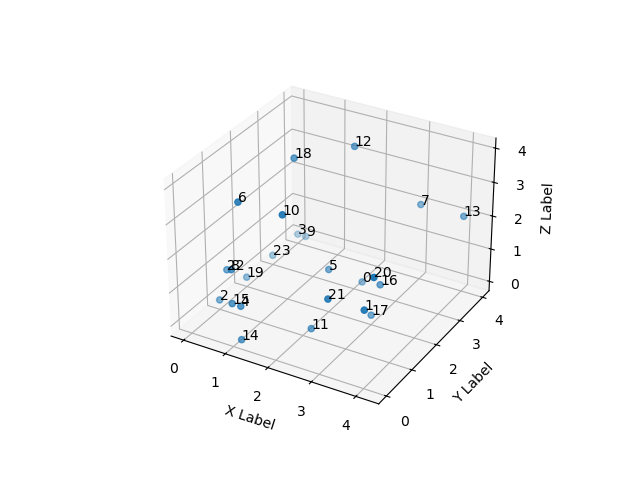

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

positions = lattice_x[None,:]*test_sites[:,0][:,None] + lattice_y[None,:] * test_sites[:,1][:,None] + lattice_z[None,:] * test_sites[:,2][:,None] + lattice_s[test_sites[:,3]]

ax.scatter(positions[:,0], positions[:,1], positions[:,2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

for i in range(test_sites.shape[0]):
    ax.text(positions[i,0], positions[i,1], positions[i,2], str(i))

# State reconstruction

In [15]:
tolerance = 1

@jit
def index_to_coord(index, max_distance, site_nb):
    center = max_distance // 2
    return (
        index // (max_distance**2 * site_nb**2) - center,
        index // (max_distance * site_nb**2) % max_distance - center,
        index // site_nb**2 % max_distance - center,
        index // site_nb % site_nb,
        index % site_nb
    )  

@jit
def coord_to_index(vec, max_distance, site_nb):
    center = max_distance // 2
    return site_nb**2 * ((vec[0] + center)*max_distance**2 + (vec[1] + center) * max_distance + (vec[2] + center)) + vec[3]*site_nb + vec[4]

#@jit #(locals={'current_set': types.Set(types.UniTuple(float64, 3))})
def vector_couplings(max_distance, site_nb, tolerance):
    print("Computing vector -> couplings lookup")
    couplings = np.empty(max_distance**3*site_nb**2)
    for i in range(max_distance**3*site_nb**2):
        couplings[i] = compute_coupling(
                    *index_to_coord(i, max_distance, site_nb)
                )
    # Revert the map
    print("Reverting the map")
    coupling_values = [] # OK to append to that list because O(number_spins)
    current_set = set(((0,0,0,0),))
    current_set.remove((0,0,0,0)) # HACK for type inference
    vectors = [current_set.copy()] # OK to append because O(number_spins)
    sorted_couplings = np.argsort(couplings)
    # i_max = coupling index st coupling + tolerance < cureent cursor
    # i_min = coupling index st coupling - tolerance < cureent cursor
    i_min, i_max = 0,0
    while not np.isnan(couplings[sorted_couplings[i_max]]):
        if np.isnan(couplings[sorted_couplings[i_min]]) or couplings[sorted_couplings[i_min]] - tolerance > couplings[sorted_couplings[i_max]] + tolerance:
            # Depile du côté des maxima (ie on retire un vecteur au set)
            vec = index_to_coord(sorted_couplings[i_max], max_distance, site_nb)
            current_set.remove(vec) # We want unmutable type here
            coupling_values.append(couplings[sorted_couplings[i_max]] + tolerance)
            i_max += 1
        else:
            # Depile du côté des minima (ie on ajoute un vecteur au set)
            vec = index_to_coord(sorted_couplings[i_min], max_distance, site_nb)
            current_set.add(vec) # We want unmutable type here
            coupling_values.append(couplings[sorted_couplings[i_min]] - tolerance)
            i_min += 1
        vectors.append(current_set.copy())
    return np.array(coupling_values), vectors
#vector_couplings(tolerance = 0.01, max_distance = lattice_size*2, site_nb = site_nb)

In [16]:
@jit
def cost_function(sites, couplings):
    couplings_theory = couplings(sites)
    cost = 0
    for i in range(sites.shape[0]-1):
        for j in range(i+1, sites.shape[0]):
            if np.isnan(couplings[i,j]):
                continue
            x = sites[i][0] - sites[j][0]
            y = sites[i][1] - sites[j][1]
            z = sites[i][2] - sites[j][2]
            cost += (couplings[i,j] - compute_coupling(x, y, z, sites[i][3], sites[j][3]))**2
    return cost

#def get_placing_order(couplings):
    

def compute_sites(couplings, lattice_size = 5, tolerance = 0.01):
    print("Begin")
    n_placed = 1
    n_tot = couplings.shape[0]
    couplings_vectors_tup = vector_couplings(tolerance = tolerance, max_distance = lattice_size*2, site_nb = site_nb) # TODO better names
    possible_configurations = []
    for i in range(site_nb):
        c = np.zeros((n_tot, 4), dtype = np.int64)
        c[0][3] = i
        possible_configurations.append(c)
        
    current_couplings = np.empty(n_tot) # stores current coupling values to other spins

    print("Initialization successful")
    while n_placed < n_tot:
        print(f"Placing {n_placed}")
        # First place them in order
        n_to_place = n_placed

        for i in range(n_tot):
            current_couplings[i] = np.nanmax([couplings[n_to_place, i], couplings[i, n_to_place]])
        # Be careful, position relative to n_to_place-1
        candidates = couplings_vectors_tup[1][np.searchsorted(couplings_vectors_tup[0], current_couplings[n_to_place-1])]
        new_possible_configurations = []
        for config in tqdm(possible_configurations):
            for candidate in candidates:
                good_candidate = True
                # First check the origin lattice site
                if candidate[4] != config[n_to_place - 1][3]:
                    continue
                for i in range(n_placed-1):
                    if np.isnan(current_couplings[i]):
                        # no data for this already placed spin
                        continue
                    coupling_candidate = compute_coupling(
                        x := candidate[0] + config[n_to_place-1][0] - config[i][0],
                        y := candidate[1] + config[n_to_place-1][1] - config[i][1],
                        z := candidate[2] + config[n_to_place-1][2] - config[i][2],
                        candidate[3],
                        config[i][3],
                    )
                    if np.isnan(coupling_candidate) or np.abs(current_couplings[i] - coupling_candidate) > tolerance:
                        good_candidate = False
                        break
                if good_candidate:
                    new_config = config.copy()
                    new_config[n_to_place] = np.array((candidate[0] + config[n_to_place-1][0], candidate[1] + config[n_to_place-1][1], candidate[2] + config[n_to_place-1][2], candidate[3]))
                    new_possible_configurations.append(new_config)
        possible_configurations = new_possible_configurations
        n_placed+=1
    return possible_configurations


In [ ]:
final_configs = compute_sites(test_couplings, tolerance = 0.005)

Begin
Computing vector -> couplings lookup
Reverting the map
Initialization successful
Placing 1


/tmp/ipykernel_775710/552860360.py:38: RuntimeWarning: All-NaN axis encountered
  current_couplings[i] = np.nanmax([couplings[n_to_place, i], couplings[i, n_to_place]])


  0%|          | 0/2 [00:00<?, ?it/s]

Placing 2


  0%|          | 0/2647 [00:00<?, ?it/s]

In [18]:
len(final_configs)

8

/tmp/ipykernel_35830/4115954874.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


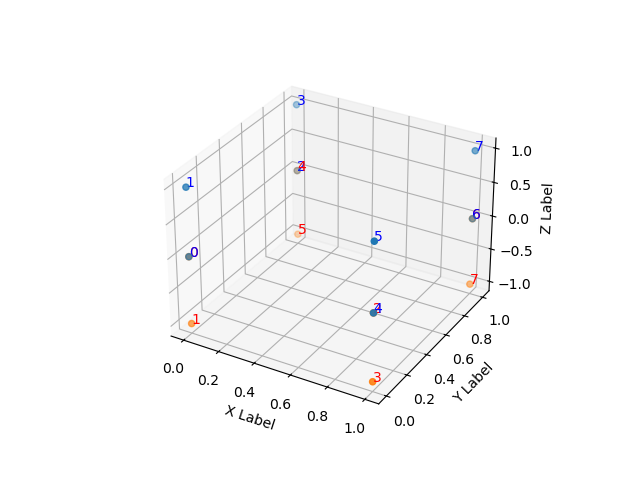

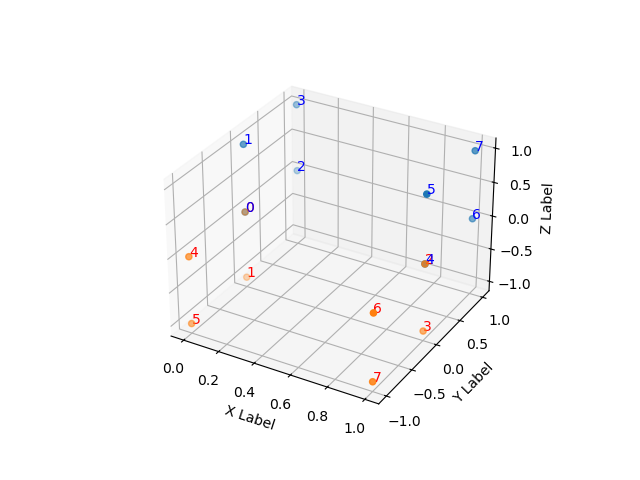

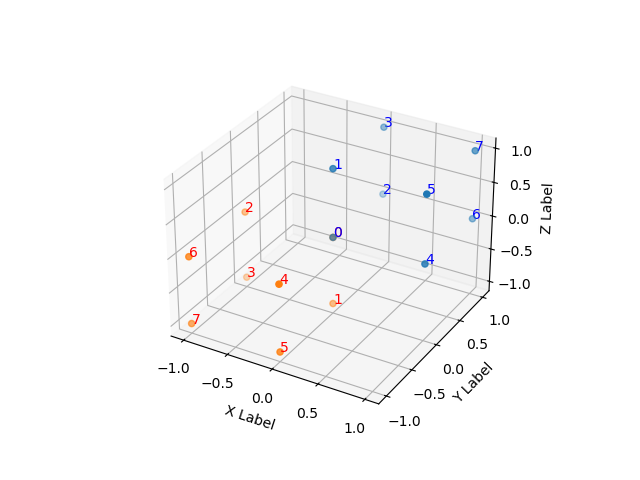

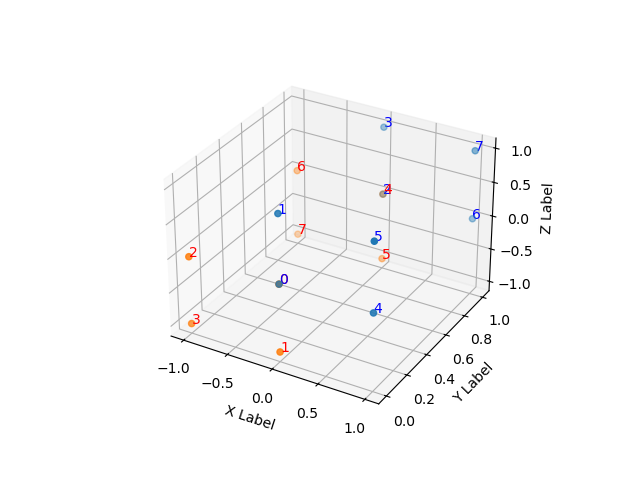

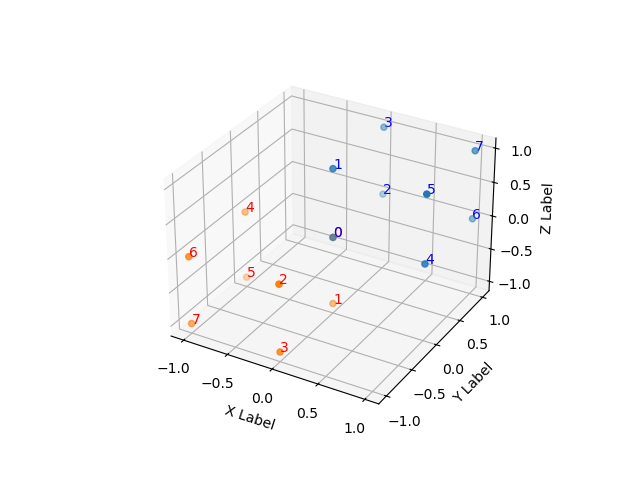

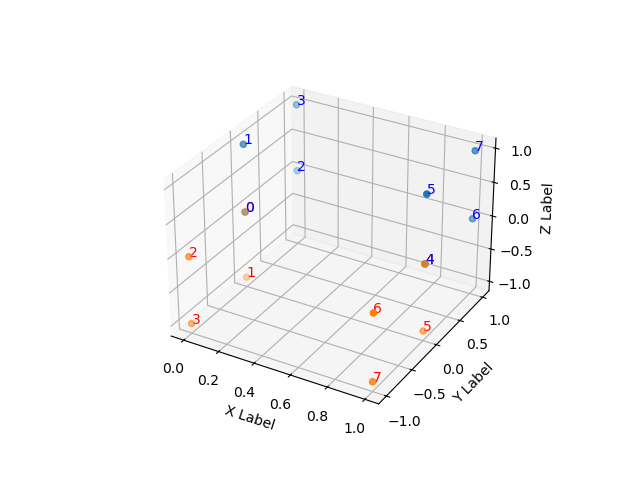

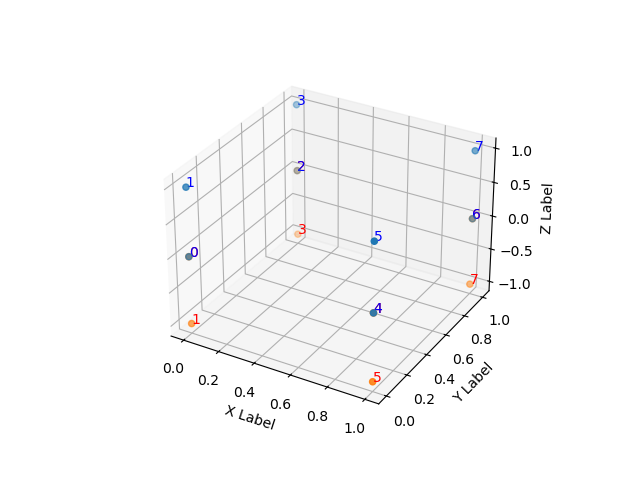

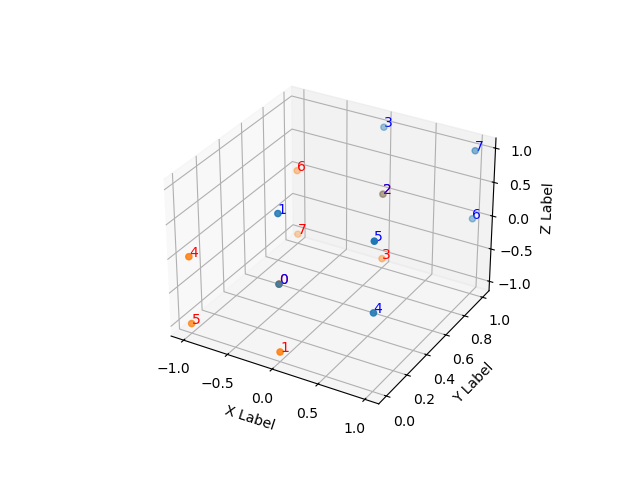

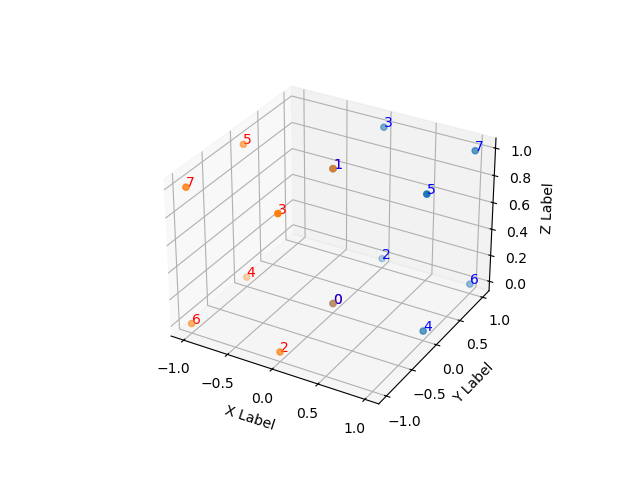

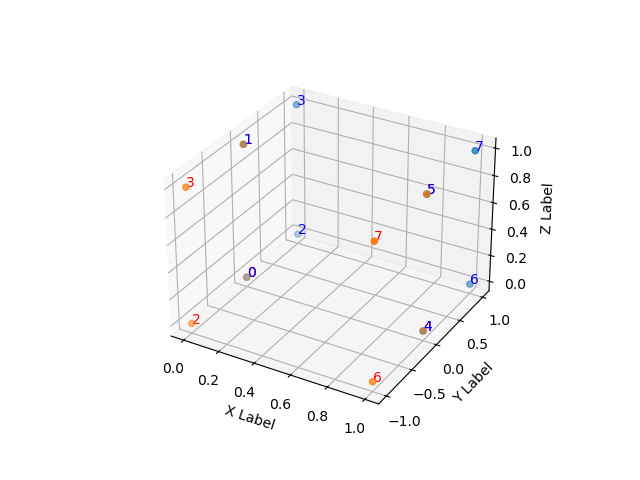

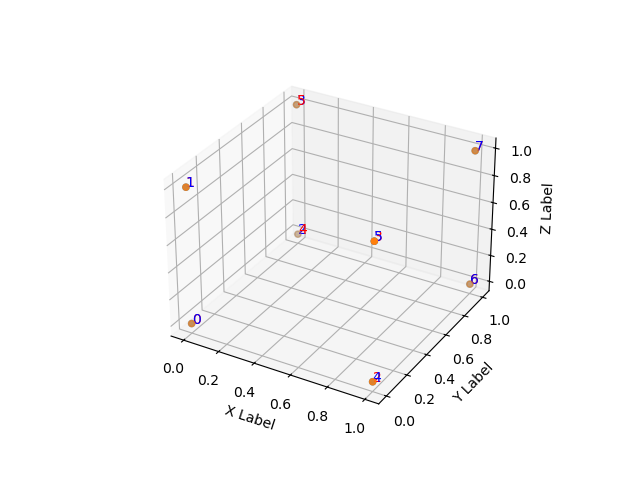

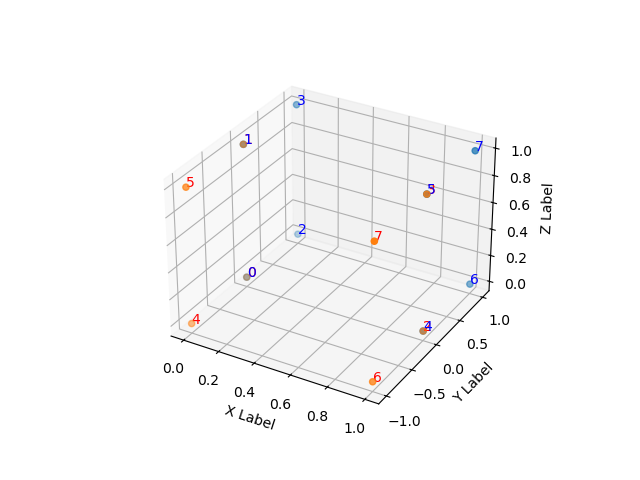

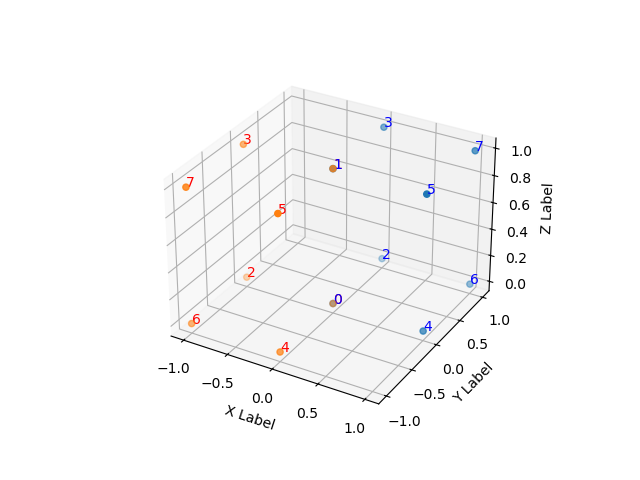

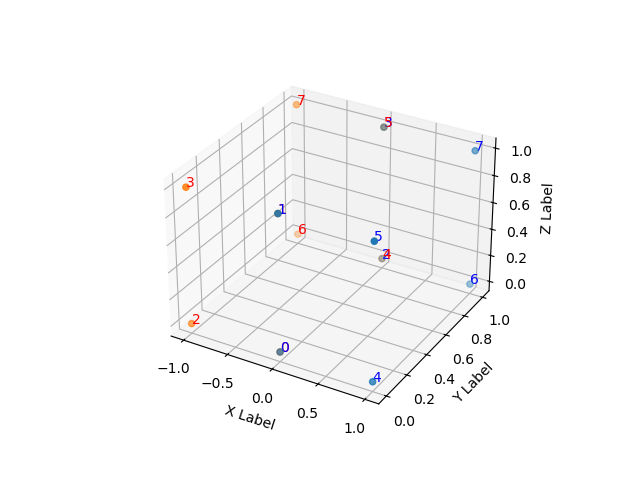

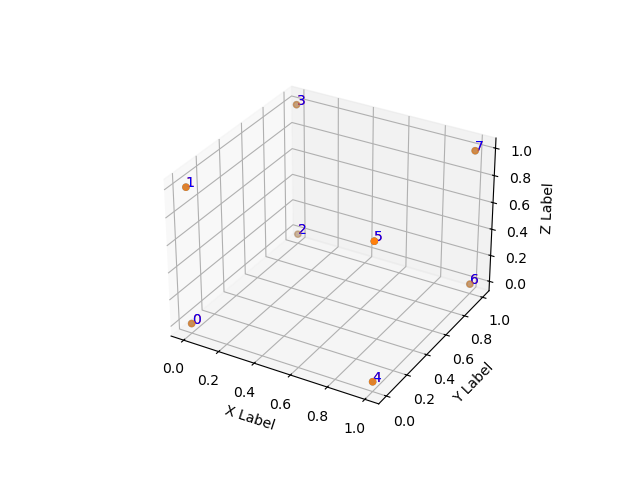

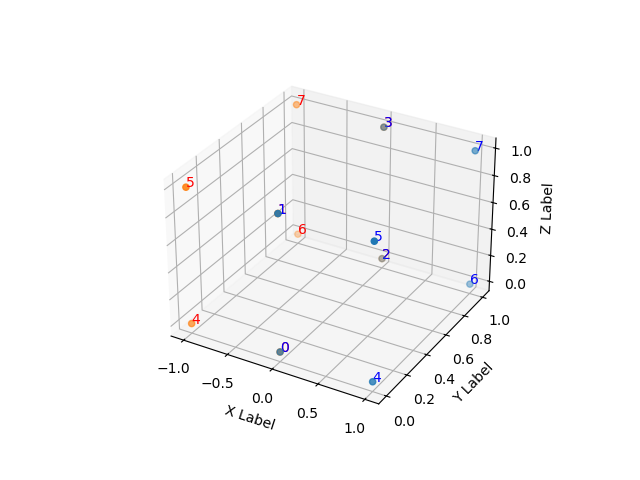